# Pion Classification with 1D CNN

Binary classifier to identify charged pions ($\pi^{\pm}$, label 2) from ProtoDUNE hit-level data using a 1D CNN with masked pooling.

In [ ]:
import os, sys

# Run from project root regardless of where the notebook is opened from
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
_utils = os.path.join(os.getcwd(), 'utils')
if _utils not in sys.path:
    sys.path.insert(0, _utils)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from general_utils import purity, efficiency, create_confusion_matrix
from evaluation_utils import (
    plot_training_curves,
    optimise_threshold,
    plot_roc_and_purity_efficiency,
    plot_confusion_matrix,
    save_results,
)

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

## Data Loading

`DATA_FILE` options:
- `"extracted-data/data_50000.pkl"` — 50k tracks (fast iteration)
- `"extracted-data/data_all.pkl"` — 279k tracks (full dataset)

In [ ]:
with open("prepared-data/train_50000.pkl", "rb") as f:
    train = pickle.load(f)
with open("prepared-data/test.pkl", "rb") as f:
    test = pickle.load(f)

x_train_norm   = train["sequences"]       # (N, 120, 2), already normalised
x_test_norm    = test["sequences"]
train_mask     = train["masks"]
test_mask      = test["masks"]
y_train_binary = train["labels"].astype(np.int64)
y_test_binary  = test["labels"].astype(np.int64)

print(f"x_train: {x_train_norm.shape}, x_test: {x_test_norm.shape}")
print(f"Train: {y_train_binary.sum():,} pions / {len(y_train_binary):,} ({100*y_train_binary.mean():.1f}%)")
print(f"Test:  {y_test_binary.sum():,} pions / {len(y_test_binary):,} ({100*y_test_binary.mean():.1f}%)")

In [40]:
class PionDataset(Dataset):
    def __init__(self, x, y, mask):
        # x: (N, 120, 2) -> (N, 2, 120) for Conv1d
        self.x = torch.FloatTensor(x).permute(0, 2, 1)
        self.y = torch.LongTensor(y)
        self.mask = torch.FloatTensor(mask.astype(np.float32))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.mask[idx], self.y[idx]


train_dataset = PionDataset(x_train_norm, y_train_binary, train_mask)
test_dataset = PionDataset(x_test_norm, y_test_binary, test_mask)

# Weighted sampler to balance classes during training
class_counts = np.bincount(y_train_binary)
sample_weights = (1.0 / class_counts)[y_train_binary]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 267, Test batches: 67


## Model Definition

In [ ]:
class MaskedGlobalAvgPool1d(nn.Module):
    """Average pooling that ignores zero-padded positions."""
    def forward(self, x, mask):
        # x: (B, C, L), mask: (B, L)
        mask_exp = mask.unsqueeze(1)  # (B, 1, L)
        x_masked = x * mask_exp
        lengths = mask_exp.sum(dim=2, keepdim=True).clamp(min=1)  # (B, 1, 1)
        return (x_masked.sum(dim=2) / lengths.squeeze(2))  # (B, C)


class FocalLoss(nn.Module):
    """Down-weights easy examples so the model focuses on hard cases."""
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce)  # probability of correct class
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()


class PionCNN(nn.Module):
    def __init__(self, in_channels=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(64)

        self.pool = MaskedGlobalAvgPool1d()
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x, mask):
        # x: (B, 2, 120), mask: (B, 120)
        x = x * mask.unsqueeze(1)  # zero out padding
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x, mask)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)


model = PionCNN(dropout=0.3).to(device)
print(f"\nParameters: {sum(p.numel() for p in model.parameters()):,}")

PionCNN(
  (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaskedGlobalAvgPool1d()
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Parameters: 41,697


## Training

In [44]:
criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    n_samples = 0
    for x, mask, y in loader:
        x, mask, y = x.to(device), mask.to(device), y.float().to(device)
        optimizer.zero_grad()
        loss = criterion(model(x, mask), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
        n_samples += len(y)
    return total_loss / n_samples


def evaluate(model, loader, criterion, threshold=0.5):
    model.eval()
    total_loss = 0
    n_samples = 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, mask, y in loader:
            x, mask, y = x.to(device), mask.to(device), y.float().to(device)
            logits = model(x, mask)
            total_loss += criterion(logits, y).item() * len(y)
            n_samples += len(y)
            all_probs.extend(torch.sigmoid(logits).cpu().numpy())
            all_labels.extend(y.cpu().numpy().astype(int))

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = (all_probs >= threshold).astype(int)

    pur = purity(all_preds, all_labels, [1], [1])
    eff = efficiency(all_preds, all_labels, [1], [1])

    return total_loss / n_samples, pur, eff, all_probs, all_labels


N_EPOCHS = 80
EARLY_STOP_PATIENCE = 15

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'purity': [], 'efficiency': []}

for epoch in range(N_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, pur, eff, _, _ = evaluate(model, test_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['purity'].append(pur)
    history['efficiency'].append(eff)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
              f"Purity: {100*pur:.1f}% | Efficiency: {100*eff:.1f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)
print(f"\nBest validation loss: {best_val_loss:.4f}")

Epoch   1 | Train: 0.1367 | Val: 0.1299 | Purity: 40.0% | Efficiency: 75.2%
Epoch   5 | Train: 0.1184 | Val: 0.1583 | Purity: 32.3% | Efficiency: 88.5%
Epoch  10 | Train: 0.1148 | Val: 0.1159 | Purity: 46.4% | Efficiency: 75.3%
Epoch  15 | Train: 0.1122 | Val: 0.1289 | Purity: 41.7% | Efficiency: 79.3%
Epoch  20 | Train: 0.1063 | Val: 0.1178 | Purity: 44.5% | Efficiency: 80.5%
Epoch  25 | Train: 0.1051 | Val: 0.1099 | Purity: 47.9% | Efficiency: 77.3%
Epoch  30 | Train: 0.0993 | Val: 0.1100 | Purity: 48.1% | Efficiency: 76.9%
Epoch  35 | Train: 0.0959 | Val: 0.1125 | Purity: 46.8% | Efficiency: 78.9%
Early stopping at epoch 37

Best validation loss: 0.1035


## Training Curves

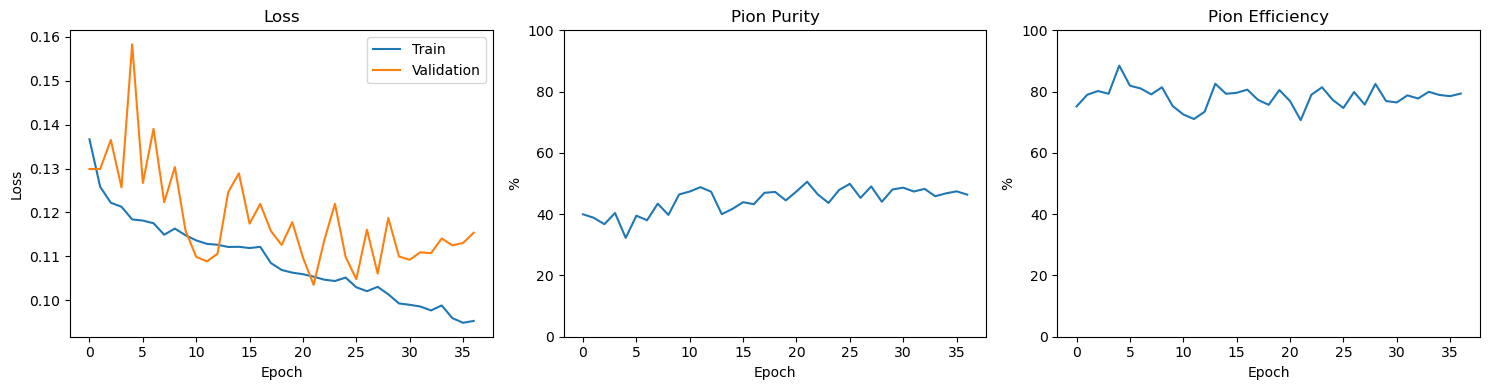

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot([100*p for p in history['purity']])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('%')
axes[1].set_title('Pion Purity')
axes[1].set_ylim([0, 100])

axes[2].plot([100*e for e in history['efficiency']])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('%')
axes[2].set_title('Pion Efficiency')
axes[2].set_ylim([0, 100])

plt.tight_layout()
plt.show()

plot_training_curves(history, 'CNN')

In [ ]:
plot_training_curves(history, 'CNN')

In [ ]:
_, _, _, test_probs, test_labels = evaluate(model, test_loader, criterion)

best_threshold = optimise_threshold(test_probs, test_labels, label='CNN', color='steelblue')
final_preds = (test_probs >= best_threshold).astype(int)

## ROC Curves

In [ ]:
plot_roc_and_purity_efficiency([
    {'probs': test_probs, 'labels': test_labels, 'threshold': best_threshold,
     'color': 'steelblue', 'label': 'CNN'}
], title='CNN \u2014 hit-level dEdX + RR')

In [ ]:
results = save_results(
    test_probs, test_labels, best_threshold,
    model_name="CNN (hit-level dEdX + RR)",
    save_path="results/cnn_hit_level.pkl",
)